### Init

In [1]:
import kuti
from kuti import model_helper as mh
from kuti import applications as apps
from kuti import tensor_ops as ops
from kuti import generic as gen
import pandas as pd, numpy as np, os

Loaded Kuti


# GET2 Files training

## Train the network on GET2 files

In [3]:
root_path = '/media/workstation/0832621B32620DCE/Ian/'
dataset = root_path + 'mtaiq/PARA_MTAIQ_GET2_official_dataset.csv'
ids = pd.read_csv(dataset)

print('ID for PARA Dataset')
ids

# input_shape = (None, None, 3)
# features_root = root_path + 'features_get2/'
# images_path = '/media/workstation/0832621B32620DCE/PARA_Dataset/PARA'

ID for PARA Dataset


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set
0,session1,iaa_pub1_.jpg,3.809524,3.923810,session1_iaa_pub1_.jpg,training
1,session1,iaa_pub2_.jpg,3.142857,3.385714,session1_iaa_pub2_.jpg,training
2,session1,iaa_pub3_.jpg,2.928571,3.128571,session1_iaa_pub3_.jpg,training
3,session1,iaa_pub4_.jpg,3.428571,3.752381,session1_iaa_pub4_.jpg,training
4,session1,iaa_pub5_.jpg,3.214286,3.538095,session1_iaa_pub5_.jpg,training
...,...,...,...,...,...,...
31215,session340,iaa_pub23744_.jpg,3.500000,3.608333,session340_iaa_pub23744_.jpg,validation
31216,session137,iaa_pub9552_.jpg,3.425000,3.720000,session137_iaa_pub9552_.jpg,validation
31217,session256,iaa_pub17866_.jpg,3.023810,3.233333,session256_iaa_pub17866_.jpg,validation
31218,session134,iaa_pub9349_.jpg,4.022727,4.154545,session134_iaa_pub9349_.jpg,validation


### Train on MLSP wide features (GET2 FEATURES)

In [4]:
# features_file = root_path + 'features/irnv2_mlsp_wide_orig/i1[orig]_lfinal_o1[5,5,16928]_r1.h5'
features_file = root_path + 'features_get2/irnv2_mlsp_wide_orig/grp:1 i:1[orig] lay:final o:1[5,5,16928].h5'


fc1_size = 2048
image_size = '[orig]'
input_size = (5,5,16928)
model_name = features_file.split('/')[-2]

loss         = dict(head_aesthetic_out = 'MSE', head_quality_out = 'MSE')
loss_weights = dict(head_aesthetic_out = 1.0,   head_quality_out = 1.0)
metrics      = dict(head_aesthetic_out = ['MAE', ops.plcc_tf], head_quality_out = ['MAE', ops.plcc_tf])

bn = 2
fc_sizes = [fc1_size, fc1_size/2, fc1_size/8,  1]
dropout_rates = [0.25, 0.25, 0.5, 0]

# monitor_metric = 'val_plcc_tf'; 
monitor_mode = 'max'
monitor_metric = 'val_head_aesthetic_out_plcc_tf'
outputs = [['aestheticScore'], ['qualityScore']]

# MODEL DEF
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
import keras

input_feats = Input(shape=input_size, dtype='float32')

# SINGLE-block
x = apps.inception_block(input_feats, size=1024)
x = GlobalAveragePooling2D(name='final_GAP')(x)

pred_aesthetic = apps.fc_layers(x, name       = 'head_aesthetic',
                                fc_sizes      = fc_sizes,
                                dropout_rates = dropout_rates,
                                batch_norm    = bn)

pred_quality = apps.fc_layers(x, name       = 'head_quality',
                              fc_sizes      = fc_sizes,
                              dropout_rates = dropout_rates,
                              batch_norm    = bn)                 

model = Model(inputs=input_feats, outputs=[pred_aesthetic, pred_quality]) #

gen_params = dict(batch_size    = 128,
                  data_path     = features_file,                  
                  input_shape   = input_size,
                  inputs        = ['sessionId_imageName'],
                  outputs       = outputs, 
                  random_group  = False,
                  fixed_batches = True)

helper = mh.ModelHelper(model, model_name, ids, 
                     max_queue_size = 128,
                     loss           = loss,
                     metrics        = metrics,
                     monitor_metric = monitor_metric, 
                     monitor_mode   = monitor_mode,
                     multiproc      = False, workers = 1,
#                      multiproc      = True, workers = 3,
                     early_stop_patience = 5,
                     logs_root      = root_path + 'logs',
                     models_root    = root_path + 'models',
                     gen_params     = gen_params)

helper.model_name.update(fc1 = '[%d]' % fc1_size,
                         im  = image_size,
                         bn  = bn,
                         do  = str(dropout_rates).replace(' ',''),
                         mon = '[%s]' % monitor_metric,
                         ds  = '[%s]' % os.path.split(dataset)[1])

print(helper.model_name())

irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]


2023-01-31 13:49:23.759520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 13:49:23.786159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 13:49:23.786362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 13:49:23.786946: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [5]:
for lr in [1e-4,1e-5,1e-6]:
    helper.load_model()
    helper.train(lr=lr, epochs=20)

NameError: name 'helper' is not defined

### Test without augmentation

In [5]:
print('After training')

helper.load_model(root_path + 'models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]')
test_gen = helper.make_generator(ids[ids.set=='test'])
helper.validate(test_gen, verbose=2)



After training
Model weights loaded: /media/workstation/0832621B32620DCE/Ian/models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Validating performance


2023-01-31 13:50:06.698276: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2023-01-31 13:50:14.044455: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


36/36 - 180s - loss: 0.1228 - head_aesthetic_out_loss: 0.0621 - head_quality_out_loss: 0.0607 - head_aesthetic_out_MAE: 0.1966 - head_aesthetic_out_plcc_tf: 0.9137 - head_quality_out_MAE: 0.1931 - head_quality_out_plcc_tf: 0.9188 - 180s/epoch - 5s/step
head_aesthetic_out_MAE:     0.19663752615451813
head_aesthetic_out_loss:    0.062127988785505295
head_aesthetic_out_plcc_tf: 0.9137099385261536
head_quality_out_MAE:       0.19310589134693146
head_quality_out_loss:      0.060700468719005585
head_quality_out_plcc_tf:   0.9187530875205994
loss:                       0.12282846868038177


{'loss': 0.12282846868038177,
 'head_aesthetic_out_loss': 0.062127988785505295,
 'head_quality_out_loss': 0.060700468719005585,
 'head_aesthetic_out_MAE': 0.19663752615451813,
 'head_aesthetic_out_plcc_tf': 0.9137099385261536,
 'head_quality_out_MAE': 0.19310589134693146,
 'head_quality_out_plcc_tf': 0.9187530875205994}

Model weights loaded: /media/workstation/0832621B32620DCE/Ian/models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Model outputs: ['head_aesthetic_out', 'head_quality_out']
Output column: ['aestheticScore']
Testing single prediction
SRCC/PLCC: 0.881/0.917


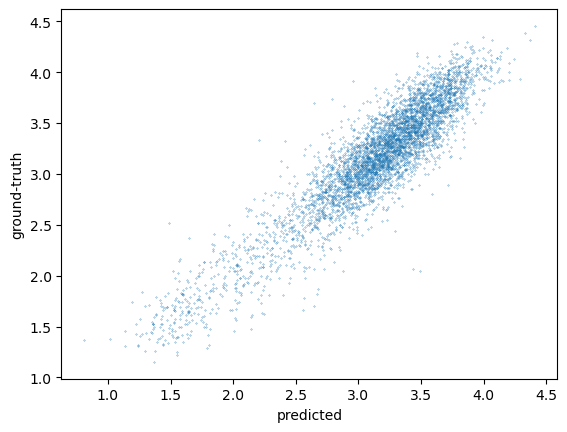

In [35]:
# model_name = root_path + 'models/irnv2_mlsp_wide_orig/model'
# uncomment the following line to use the trained model (default)
model_name = ''

if helper.load_model(model_name=root_path + 'models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]'):
    y_test, y_pred, SRCC_test, PLCC_test =\
        apps.test_rating_model(helper, output_column=['aestheticScore'])

Model weights loaded: /media/workstation/0832621B32620DCE/Ian/models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Model outputs: ['head_aesthetic_out', 'head_quality_out']
Output column: ['qualityScore']
Testing single prediction
SRCC/PLCC: 0.882/0.922


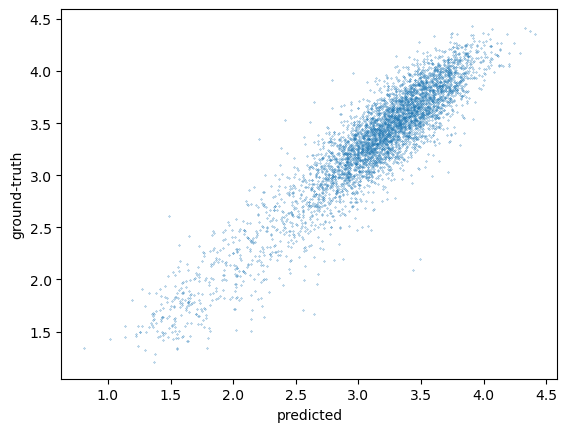

In [36]:
model_name = ''

if helper.load_model(root_path + 'models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]'):
    y_test, y_pred, SRCC_test, PLCC_test =\
        apps.test_rating_model(helper, output_column=['qualityScore'])

Model weights loaded: /media/workstation/0832621B32620DCE/Ian/models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Model outputs: ['head_aesthetic_out', 'head_quality_out']
Output column: ['aestheticScore', 'qualityScore']
Testing single prediction
SRCC/PLCC: 0.013/0.009


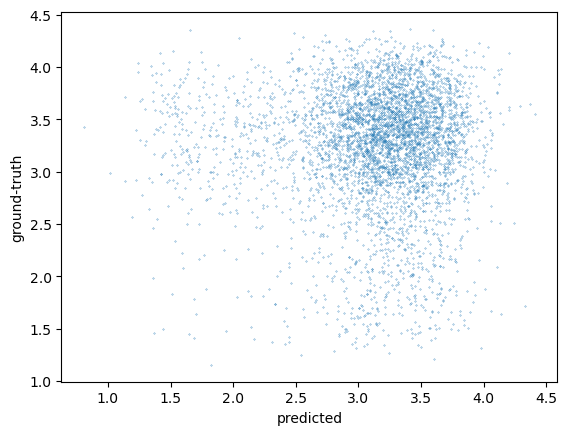

In [37]:
model_name = ''

if helper.load_model(root_path + 'models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]'):
    y_test, y_pred, SRCC_test, PLCC_test =\
        apps.test_rating_model(helper, output_column=['aestheticScore', 'qualityScore'])

# GET3 Files training


### Train the network on GET3 files 

In [2]:

root_path = '/media/workstation/0832621B32620DCE/Ian/'
dataset = root_path + 'mtaiq/PARA_MTAIQ_GET3_official_dataset.csv'
ids = pd.read_csv(dataset)

print('ID for PARA Dataset')
ids

# input_shape = (None, None, 3)
# features_root = root_path + 'features_get3/'
# images_path = '/media/workstation/0832621B32620DCE/PARA_Dataset/PARA'

ID for PARA Dataset


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set
0,session1,iaa_pub2_.jpg,3.104167,3.341667,session1_iaa_pub2_.jpg,training
1,session1,iaa_pub5_.jpg,3.187500,3.491667,session1_iaa_pub5_.jpg,training
2,session1,iaa_pub6_.jpg,3.562500,3.866667,session1_iaa_pub6_.jpg,training
3,session1,iaa_pub9_.jpg,2.625000,2.904167,session1_iaa_pub9_.jpg,training
4,session1,iaa_pub10_.jpg,2.895833,3.158333,session1_iaa_pub10_.jpg,training
...,...,...,...,...,...,...
31215,session5,iaa_pub296_.jpg,3.840000,3.952000,session5_iaa_pub296_.jpg,validation
31216,session14,iaa_pub922_.jpg,4.152174,4.226087,session14_iaa_pub922_.jpg,validation
31217,session331,iaa_pub23123_.jpg,3.820000,3.848000,session331_iaa_pub23123_.jpg,validation
31218,session225,iaa_pub15749_.jpg,3.041667,3.150000,session225_iaa_pub15749_.jpg,validation


### Train on MLSP wide features

In [19]:
# features_file = root_path + 'features/irnv2_mlsp_wide_orig/i1[orig]_lfinal_o1[5,5,16928]_r1.h5'
features_file = root_path + 'features_get3/irnv2_mlsp_wide_orig/grp:1 i:1[orig] lay:final o:1[5,5,16928].h5'


fc1_size = 2048
image_size = '[orig]'
input_size = (5,5,16928)
model_name = features_file.split('/')[-2]

loss         = dict(head_aesthetic_out = 'MSE', head_quality_out = 'MSE')
loss_weights = dict(head_aesthetic_out = 1.0,   head_quality_out = 1.0)
metrics      = dict(head_aesthetic_out = ['MAE', ops.plcc_tf], head_quality_out = ['MAE', ops.plcc_tf])

bn = 2
fc_sizes = [fc1_size, fc1_size/2, fc1_size/8,  1]
dropout_rates = [0.25, 0.25, 0.5, 0]

# monitor_metric = 'val_plcc_tf'; 
monitor_mode = 'max'
monitor_metric = 'val_head_aesthetic_out_plcc_tf'
outputs = [['aestheticScore'], ['qualityScore']]

# MODEL DEF
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
import keras

input_feats = Input(shape=input_size, dtype='float32')

# SINGLE-block
x = apps.inception_block(input_feats, size=1024)
x = GlobalAveragePooling2D(name='final_GAP')(x)

pred_aesthetic = apps.fc_layers(x, name       = 'head_aesthetic',
                                fc_sizes      = fc_sizes,
                                dropout_rates = dropout_rates,
                                batch_norm    = bn)

pred_quality = apps.fc_layers(x, name       = 'head_quality',
                              fc_sizes      = fc_sizes,
                              dropout_rates = dropout_rates,
                              batch_norm    = bn)                 

model = Model(inputs=input_feats, outputs=[pred_aesthetic, pred_quality]) #

gen_params = dict(batch_size    = 128,
                  data_path     = features_file,                  
                  input_shape   = input_size,
                  inputs        = ['sessionId_imageName'],
                  outputs       = outputs, 
                  random_group  = False,
                  fixed_batches = True)

helper = mh.ModelHelper(model, model_name, ids, 
                     max_queue_size = 128,
                     loss           = loss,
                     metrics        = metrics,
                     monitor_metric = monitor_metric, 
                     monitor_mode   = monitor_mode,
                     multiproc      = False, workers = 1,
#                      multiproc      = True, workers = 3,
                     early_stop_patience = 5,
                     logs_root      = root_path + 'logs',
                     models_root    = root_path + 'models_get3',
                     gen_params     = gen_params)

helper.model_name.update(fc1 = '[%d]' % fc1_size,
                         im  = image_size,
                         bn  = bn,
                         do  = str(dropout_rates).replace(' ',''),
                         mon = '[%s]' % monitor_metric,
                         ds  = '[%s]' % os.path.split(dataset)[1])

print(helper.model_name())

irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]


In [6]:
for lr in [1e-4,1e-5,1e-6]:
    helper.load_model()
    helper.train(lr=lr, epochs=20)

Model NOT loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5 does not exist
Training model: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]
Epoch 1/20
170/170 [==============================] - 723s 4s/step - loss: 24.6871 - head_aesthetic_out_loss: 11.7403 - head_quality_out_loss: 12.9467 - head_aesthetic_out_MAE: 3.0696 - head_aesthetic_out_plcc_tf: 0.2320 - head_quality_out_MAE: 3.2193 - head_quality_out_plcc_tf: 0.2217 - val_loss: 16.4803 - val_head_aesthetic_out_loss: 7.6598 - val_head_quality_out_loss: 8.8205 - val_head_aesthetic_out_MAE: 2.7179 - val_head_aesthetic_out_plcc_tf: 0.4432 - val_head_quality_out_MAE: 2.9360 - val_head_quality_out_plcc_tf: 0.5959
Epoch 2/20
170/170 [================

### Test without augmentation

In [8]:
print('After training')

helper.load_model()
test_gen = helper.make_generator(ids[ids.set=='test'])
helper.validate(test_gen, verbose=2)

After training
Model weights loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Validating performance
36/36 - 76s - loss: 0.1147 - head_aesthetic_out_loss: 0.0601 - head_quality_out_loss: 0.0546 - head_aesthetic_out_MAE: 0.1943 - head_aesthetic_out_plcc_tf: 0.9193 - head_quality_out_MAE: 0.1837 - head_quality_out_plcc_tf: 0.9226 - 76s/epoch - 2s/step
head_aesthetic_out_MAE:     0.19433808326721191
head_aesthetic_out_loss:    0.0601111464202404
head_aesthetic_out_plcc_tf: 0.9192626476287842
head_quality_out_MAE:       0.18374060094356537
head_quality_out_loss:      0.05463162809610367
head_quality_out_plcc_tf:   0.922592282295227
loss:                       0.11474278569221497


{'loss': 0.11474278569221497,
 'head_aesthetic_out_loss': 0.0601111464202404,
 'head_quality_out_loss': 0.05463162809610367,
 'head_aesthetic_out_MAE': 0.19433808326721191,
 'head_aesthetic_out_plcc_tf': 0.9192626476287842,
 'head_quality_out_MAE': 0.18374060094356537,
 'head_quality_out_plcc_tf': 0.922592282295227}

Model weights loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Model outputs: ['head_aesthetic_out', 'head_quality_out']
Output column: ['aestheticScore']
Testing single prediction
SRCC/PLCC: 0.887/0.922


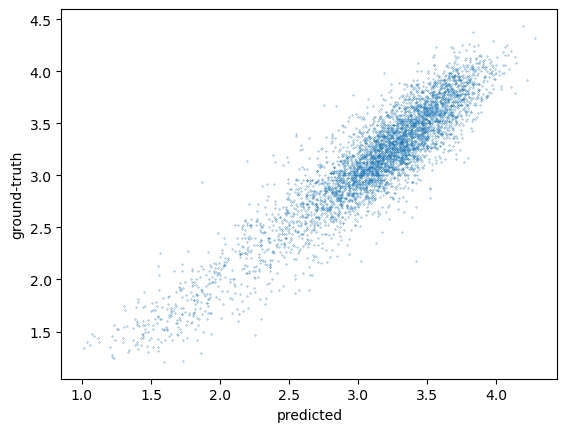

In [9]:
# model_name = root_path + 'models/irnv2_mlsp_wide_orig/model'
# uncomment the following line to use the trained model (default)
model_name = ''

if helper.load_model(model_name=model_name):
    y_test, y_pred, SRCC_test, PLCC_test =\
        apps.test_rating_model(helper, output_column=['aestheticScore'])

Model weights loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Model outputs: ['head_aesthetic_out', 'head_quality_out']
Output column: ['qualityScore']
Testing single prediction
SRCC/PLCC: 0.887/0.927


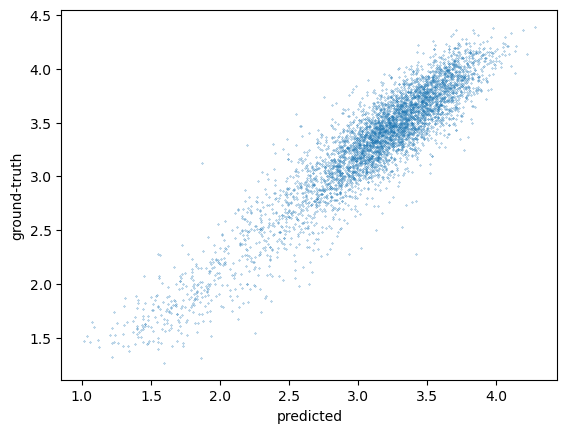

In [10]:
model_name = ''

if helper.load_model(model_name=model_name):
    y_test, y_pred, SRCC_test, PLCC_test =\
        apps.test_rating_model(helper, output_column=['qualityScore'])

Model weights loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Model outputs: ['head_aesthetic_out', 'head_quality_out']
Output column: ['aestheticScore', 'qualityScore']
Testing single prediction
SRCC/PLCC: 0.019/0.016


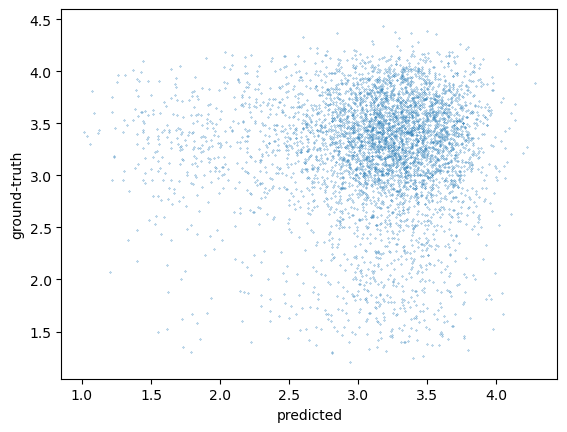

In [11]:
model_name = ''

if helper.load_model(model_name=model_name):
    y_test, y_pred, SRCC_test, PLCC_test =\
        apps.test_rating_model(helper, output_column=['aestheticScore', 'qualityScore'])

In [23]:
# if helper.load_model(model_name=root_patmodel_name):
#     y_test, y_pred, SRCC_test, PLCC_test =\
#         apps.test_rating_model(helper, output_column=['aestheticScore', 'qualityScore'])

print(root_path)
if helper.load_model():
        y_test, y_pred, SRCC_test, PLCC_test =\
        apps.test_rating_model(helper, output_column=['aestheticScore', 'qualityScore'])

/media/workstation/0832621B32620DCE/Ian/
Model NOT loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5 does not exist


# Train on All Users

### Train on All User Dataset

In [2]:
root_path = '/media/workstation/0832621B32620DCE/Ian/'
dataset = root_path + 'mtaiq/PARA_MTAIQ_All_User_official_dataset.csv'
ids = pd.read_csv(dataset)

print('ID for PARA Dataset')
ids

# input_shape = (None, None, 3)
# features_root = root_path + 'features_get3/'
# images_path = '/media/workstation/0832621B32620DCE/PARA_Dataset/PARA'

ID for PARA Dataset


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set
0,session328,iaa_pub22893_.jpg,1.980000,2.084000,session328_iaa_pub22893_.jpg,training
1,session232,iaa_pub16180_.jpg,3.720000,3.840000,session232_iaa_pub16180_.jpg,training
2,session125,iaa_pub8721_.jpg,2.900000,3.052000,session125_iaa_pub8721_.jpg,training
3,session139,iaa_pub9725_.jpg,3.120000,3.356000,session139_iaa_pub9725_.jpg,training
4,session79,iaa_pub5474_.jpg,3.840000,3.932000,session79_iaa_pub5474_.jpg,training
...,...,...,...,...,...,...
31215,session7,iaa_pub484_.jpg,3.540000,3.664000,session7_iaa_pub484_.jpg,validation
31216,session68,iaa_pub4700_.jpg,2.640000,2.984000,session68_iaa_pub4700_.jpg,validation
31217,session20,iaa_pub1377_.jpg,3.340000,3.428000,session20_iaa_pub1377_.jpg,validation
31218,session64,iaa_pub4477_.jpg,3.464286,3.607143,session64_iaa_pub4477_.jpg,validation


In [3]:
# features_file = root_path + 'features/irnv2_mlsp_wide_orig/i1[orig]_lfinal_o1[5,5,16928]_r1.h5'
features_file = root_path + 'features_all_user/irnv2_mlsp_wide_orig/grp:1 i:1[orig] lay:final o:1[5,5,16928].h5'


fc1_size = 2048
image_size = '[orig]'
input_size = (5,5,16928)
model_name = features_file.split('/')[-2]

loss         = dict(head_aesthetic_out = 'MSE', head_quality_out = 'MSE')
loss_weights = dict(head_aesthetic_out = 1.0,   head_quality_out = 1.0)
metrics      = dict(head_aesthetic_out = ['MAE', ops.plcc_tf], head_quality_out = ['MAE', ops.plcc_tf])

bn = 2
fc_sizes = [fc1_size, fc1_size/2, fc1_size/8,  1]
dropout_rates = [0.25, 0.25, 0.5, 0]

# monitor_metric = 'val_plcc_tf'; 
monitor_mode = 'max'
monitor_metric = 'val_head_aesthetic_out_plcc_tf'
outputs = [['aestheticScore'], ['qualityScore']]

# MODEL DEF
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
import keras

input_feats = Input(shape=input_size, dtype='float32')

# SINGLE-block
x = apps.inception_block(input_feats, size=1024)
x = GlobalAveragePooling2D(name='final_GAP')(x)

pred_aesthetic = apps.fc_layers(x, name       = 'head_aesthetic',
                                fc_sizes      = fc_sizes,
                                dropout_rates = dropout_rates,
                                batch_norm    = bn)

pred_quality = apps.fc_layers(x, name       = 'head_quality',
                              fc_sizes      = fc_sizes,
                              dropout_rates = dropout_rates,
                              batch_norm    = bn)                 

model = Model(inputs=input_feats, outputs=[pred_aesthetic, pred_quality]) #

gen_params = dict(batch_size    = 128,
                  data_path     = features_file,                  
                  input_shape   = input_size,
                  inputs        = ['sessionId_imageName'],
                  outputs       = outputs, 
                  random_group  = False,
                  fixed_batches = True)

helper = mh.ModelHelper(model, model_name, ids, 
                     max_queue_size = 128,
                     loss           = loss,
                     metrics        = metrics,
                     monitor_metric = monitor_metric, 
                     monitor_mode   = monitor_mode,
                     multiproc      = False, workers = 1,
#                      multiproc      = True, workers = 3,
                     early_stop_patience = 5,
                     logs_root      = root_path + 'logs_all_user',
                     models_root    = root_path + 'models_all_user',
                     gen_params     = gen_params)

helper.model_name.update(fc1 = '[%d]' % fc1_size,
                         im  = image_size,
                         bn  = bn,
                         do  = str(dropout_rates).replace(' ',''),
                         mon = '[%s]' % monitor_metric,
                         ds  = '[%s]' % os.path.split(dataset)[1])

print(helper.model_name())

2023-02-04 17:35:39.782667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 17:35:40.251016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 17:35:40.251214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 17:35:40.251775: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_All_User_official_da fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]


In [4]:
for lr in [1e-4,1e-5,1e-6]:
    helper.load_model()
    helper.train(lr=lr, epochs=20)

Model NOT loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_All_User_official_da fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5 does not exist
Training model: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_All_User_official_da fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]
Epoch 1/20


2023-02-04 17:36:39.497969: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2023-02-04 17:36:45.845521: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


170/170 [==============================] - 693s 4s/step - loss: 24.5450 - head_aesthetic_out_loss: 11.7454 - head_quality_out_loss: 12.7996 - head_aesthetic_out_MAE: 3.0599 - head_aesthetic_out_plcc_tf: 0.2207 - head_quality_out_MAE: 3.2139 - head_quality_out_plcc_tf: 0.2236 - val_loss: 17.3890 - val_head_aesthetic_out_loss: 7.9432 - val_head_quality_out_loss: 9.4459 - val_head_aesthetic_out_MAE: 2.7826 - val_head_aesthetic_out_plcc_tf: 0.5826 - val_head_quality_out_MAE: 3.0396 - val_head_quality_out_plcc_tf: 0.5645
Epoch 2/20
170/170 [==============================] - 597s 4s/step - loss: 19.7957 - head_aesthetic_out_loss: 9.3730 - head_quality_out_loss: 10.4227 - head_aesthetic_out_MAE: 2.7445 - head_aesthetic_out_plcc_tf: 0.2615 - head_quality_out_MAE: 2.9174 - head_quality_out_plcc_tf: 0.2558 - val_loss: 13.4825 - val_head_aesthetic_out_loss: 7.0991 - val_head_quality_out_loss: 6.3834 - val_head_aesthetic_out_MAE: 2.6221 - val_head_aesthetic_out_plcc_tf: 0.6021 - val_head_quality_o

### Test without augmentation

In [5]:
print('After training')

helper.load_model()
test_gen = helper.make_generator(ids[ids.set=='test'])
helper.validate(test_gen, verbose=2)

After training
Model weights loaded: irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_All_User_official_da fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5
Validating performance
36/36 - 147s - loss: 0.1091 - head_aesthetic_out_loss: 0.0552 - head_quality_out_loss: 0.0540 - head_aesthetic_out_MAE: 0.1838 - head_aesthetic_out_plcc_tf: 0.9172 - head_quality_out_MAE: 0.1818 - head_quality_out_plcc_tf: 0.9204 - 147s/epoch - 4s/step
head_aesthetic_out_MAE:     0.18383386731147766
head_aesthetic_out_loss:    0.05516722425818443
head_aesthetic_out_plcc_tf: 0.917154848575592
head_quality_out_MAE:       0.18180321156978607
head_quality_out_loss:      0.05396800860762596
head_quality_out_plcc_tf:   0.920364260673523
loss:                       0.1091352328658104


{'loss': 0.1091352328658104,
 'head_aesthetic_out_loss': 0.05516722425818443,
 'head_quality_out_loss': 0.05396800860762596,
 'head_aesthetic_out_MAE': 0.18383386731147766,
 'head_aesthetic_out_plcc_tf': 0.917154848575592,
 'head_quality_out_MAE': 0.18180321156978607,
 'head_quality_out_plcc_tf': 0.920364260673523}